In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [13]:
oil_prices = pd.read_csv("data\monthly_oil_cost_1988-2025.csv", usecols=["Date", "Price"])
oil_prices

,Date,Price
0,03/01/2025,70.88
1,02/01/2025,72.81
2,01/01/2025,75.67
3,12/01/2024,74.24
4,11/01/2024,71.84
...,...,...
436,11/01/1988,14.05
437,10/01/1988,12.74
438,09/01/1988,12.24
439,08/01/1988,14.60


In [14]:
freight_prices = pd.read_csv("data\cleanFreight.csv", usecols=["Date", "Price"])
freight_prices

,Date,Price
0,03/01/2025,660.00
1,02/01/2025,670.00
2,01/01/2025,662.00
3,12/01/2024,625.00
4,11/01/2024,663.00
...,...,...
269,10/01/2002,721.00
270,09/01/2002,683.00
271,08/01/2002,728.00
272,07/01/2002,742.00


In [15]:
oil_prices["Price"] = oil_prices["Price"].astype(float)
freight_prices["Price"] = freight_prices["Price"].replace(',', '', regex=True).astype(float)

oil_prices["Date"] = pd.to_datetime(oil_prices["Date"], format="%m/%d/%Y")
freight_prices["Date"] = pd.to_datetime(freight_prices["Date"], format="%m/%d/%Y")

df = pd.merge(freight_prices, oil_prices, on="Date", suffixes=("_freight", "_oil"))
df.sort_values(by="Date", inplace=True)
df.set_index("Date", inplace=True)
df.index.freq = 'MS'
df

,Price_freight,Price_oil
Date,,
2002-06-01,733.0,25.58
2002-07-01,742.0,25.44
2002-08-01,728.0,27.47
2002-09-01,683.0,28.75
2002-10-01,721.0,25.72
...,...,...
2024-11-01,663.0,71.84
2024-12-01,625.0,74.24
2025-01-01,662.0,75.67


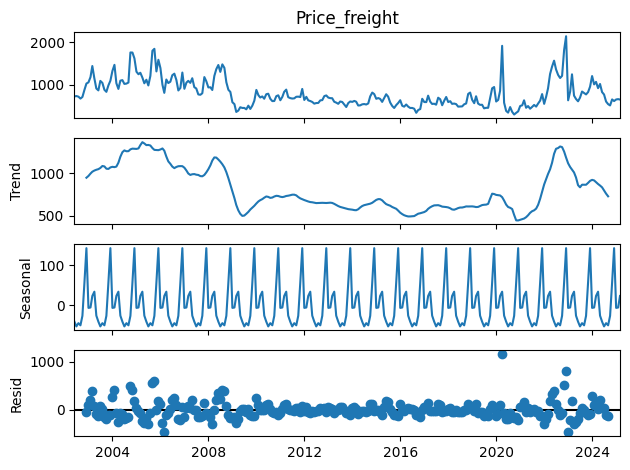

In [16]:
decomposition = sm.tsa.seasonal_decompose(df['Price_freight'], model='additive')

# Извлечем компоненты: тренд, сезонность и остатки
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# Визуализируем результаты
decomposition.plot()
plt.show()


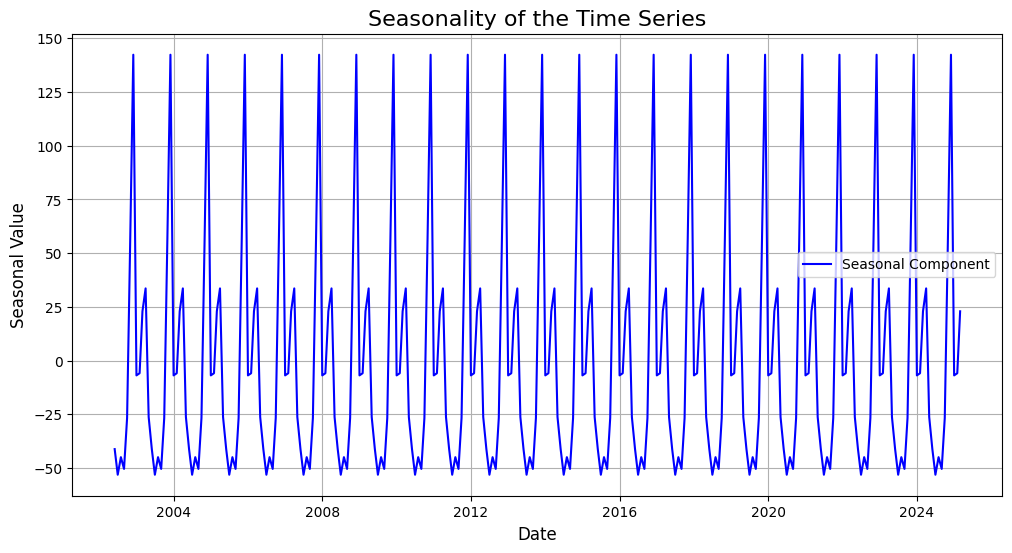

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(seasonal, label='Seasonal Component', color='blue')
plt.title('Seasonality of the Time Series', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Seasonal Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

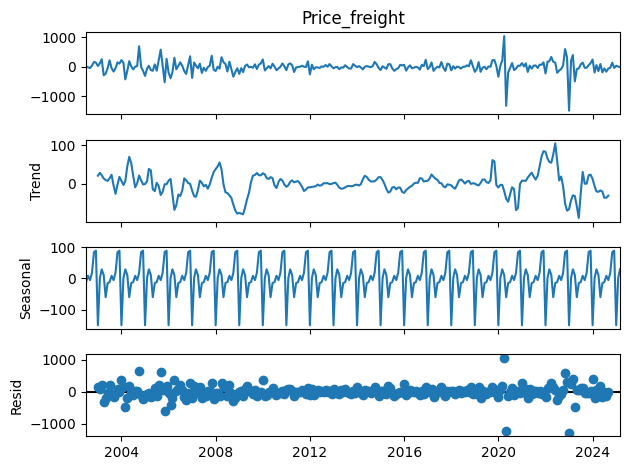

In [18]:
df_diff = df.diff().dropna()
decomposition_diff = sm.tsa.seasonal_decompose(df_diff['Price_freight'], model='additive')

# Извлечем компоненты: тренд, сезонность и остатки
trend_diff = decomposition.trend
seasonal_diff = decomposition.seasonal
residual_diff = decomposition.resid
# Визуализируем результаты
decomposition_diff.plot()
plt.show()

In [ ]:
df_diff = df.diff(12).dropna()

train_size = int(len(df_diff) * 0.8)  # 80% train, 20% test
train, test = df_diff[:train_size], df_diff[train_size:]

# Далее строим VAR-модель на df_diff:
model_varima = VAR(df_diff)
lag_results_varima = model_varima.select_order(maxlags=24)
best_lag_varima = lag_results_varima.aic
print("Лучший лаг по AIC:", best_lag_varima)


Лучший лаг по AIC: 16


In [20]:
results_varima = model_varima.fit(best_lag_varima)
print(results_varima.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Apr, 2025
Time:                     18:46:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    16.0661
Nobs:                     246.000    HQIC:                   15.5043
Log likelihood:          -2492.57    FPE:                3.71871e+06
AIC:                      15.1256    Det(Omega_mle):     2.89104e+06
--------------------------------------------------------------------
Results for equation Price_freight
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   -13.250263        14.797549           -0.895           0.371
L1.Price_freight          0.695221         0.067945           10.232           0.000
L1.Price_oil              1.898252  

In [21]:
forecast_steps = len(test)
forecast = results_varima.forecast(train.values[-best_lag_varima:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=df.columns)

Общая точность по всем переменным:
RMSE: 385.3017
MSE: 148457.3749
MAE: 214.1275



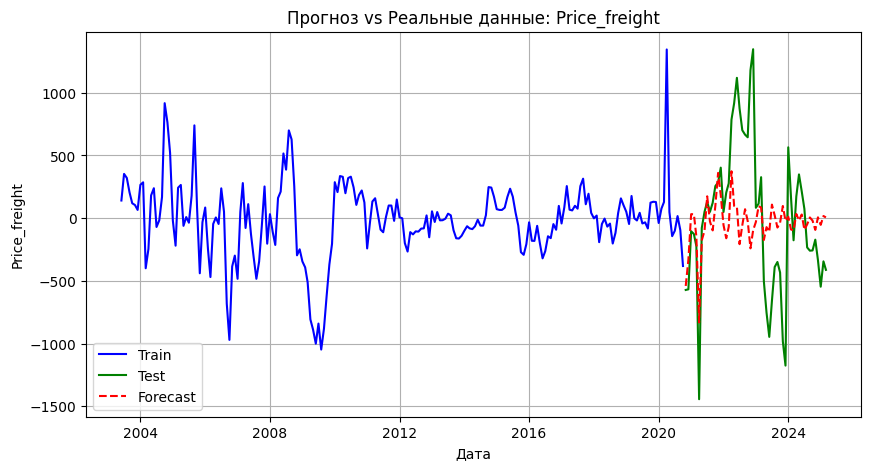

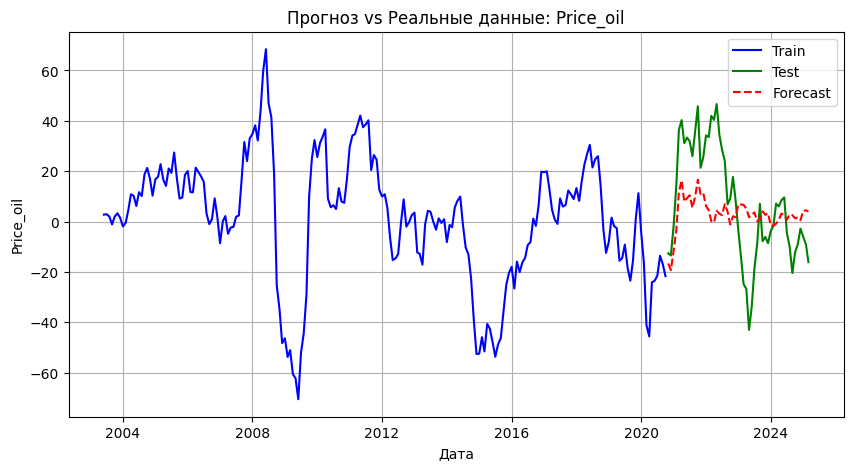

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(test, forecast_df))
mse = mean_squared_error(test, forecast_df)
mae = mean_absolute_error(test, forecast_df)


print("Общая точность по всем переменным:")
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}\n")

for col in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train[col], label='Train', color='blue')
    plt.plot(test.index, test[col], label='Test', color='green')
    plt.plot(forecast_df.index, forecast_df[col], label='Forecast', color='red', linestyle='--')

    plt.title(f'Прогноз vs Реальные данные: {col}')
    plt.xlabel('Дата')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()
